## [Mestrado] 5.1 Experimentos com autoencoder LSTM usando instâncias simuladas agrupadas (somente melhor caso)

### Carregamento e tratamento dos dados **simulados** para experimentação:

In [1]:
# Artifício para alcular tempo total do notebook Jupyter
from datetime import datetime 
start_time = datetime.now()

In [2]:
# Experimentos para defesa de mestrado (autoencoder com lstm)
# Carregamento e tratamento dos dados simulados
%matplotlib inline
import pandas as pd
import numpy as np
import logging
import warnings
import tensorflow as tf
from math import ceil
from time import time
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam

warnings.simplefilter(action='ignore')

data_path = Path('./', 'data')
random_state = 1
np.random.seed(random_state)
tf.random.set_seed(random_state)
events_names = {0: 'Normal',
                1: 'Aumento Abrupto de BSW',
                2: 'Fechamento Espúrio de DHSV',
                3: 'Intermitência Severa',
                4: 'Instabilidade de Fluxo',
                5: 'Perda Rápida de Produtividade',
                6: 'Restrição Rápida em CKP',
                7: 'Incrustação em CKP',
                8: 'Hidrato em Linha de Produção'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']
columns = ['timestamp'] + vars + ['class'] 
normal_class_code = 0
abnormal_classes_codes = [1, 2, 5, 6, 7, 8]
sample_size = 3*60              # Nas observações = segundos
min_normal_period_size = 20*60  # Nas observações = segundos
split_range = 0.6               # Porcentagem de separação entre treino/teste
max_samples_per_period = 15     # limitação por 'segurança'
max_nan_percent = 0.1           # Para seleção de variáveis úteis
std_vars_min = 0.01             # Para seleção de variáveis úteis
disable_progressbar = True      # Para menos saídas no notebook

def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    """Gerador de lista contendo número da classe e caminho do arquivo de acordo com a fonte da instância."""    
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path
                        
                    
def load_instance(instance_path):
    """Função que carrega cada instância individualmente"""
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, sep=',', header=0)
        assert (df.columns == columns).all(), \
            f'Colunas inválidas no arquivo {str(instance_path)}: {str(df.columns.tolist())}'
        return df
    except Exception as e:
        raise Exception(f'Erro ao ler arquivo {instance_path}: {e}')
        
def extract_samples(df, class_code):
    # Obtém os rótulos das observações e seu conjunto inequívoco
    ols = list(df['class'])
    set_ols = set()
    for ol in ols:
        if ol in set_ols or np.isnan(ol):
            continue
        set_ols.add(int(ol))       
    
    # Descarta os rótulos das observações e substitui todos os nan por 0
    # (requisito da biblioteca tsfresh)
    df_vars = df.drop('class', axis=1).fillna(0)  
    
    # Inicializa objetos que serão retornados
    df_samples_train = pd.DataFrame()
    df_samples_test = pd.DataFrame()
    y_train = []
    y_test = []
            
    # Descubre o número máximo de amostras em períodos normais, transitórios e em regime
    # Obtém índices (primeiro e último) sem sobreposição com outros períodos
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)

    # Define o número inicial de amostras para o período normal
    max_samples_normal = l_idx-f_idx+1-sample_size
    if (max_samples_normal) > 0:      
        num_normal_samples = min(max_samples_per_period, max_samples_normal)
        num_train_samples = int(split_range*num_normal_samples)
        num_test_samples = num_normal_samples - num_train_samples    
    else:
        num_train_samples = 0
        num_test_samples = 0
    
    # Define o número máximo de amostras por período transitório
    transient_code = class_code + 100    
    if transient_code in set_ols:
        # Obtém índices (primeiro e último) com possível sobreposição
        # no início do período
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code)        
        max_transient_samples = l_idx-f_idx+1-sample_size
    else:
        max_transient_samples = 0            

    # Define o número máximo de amostras no período de regime
    if class_code in set_ols:
        # Obtém índices (primeiro e último) com possível sobreposição 
        # no início ou fim do período
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1
        max_in_regime_samples = l_idx-f_idx+1-sample_size
    else:
        max_in_regime_samples = 0   
        
    # Descubre o número adequado de amostras em períodos normais, transitórios e em regime
    num_transient_samples = ceil(num_test_samples/2)
    num_in_regime_samples = num_test_samples - num_transient_samples
    if (max_transient_samples >= num_transient_samples) and \
       (max_in_regime_samples < num_in_regime_samples):
        num_in_regime_samples = max_in_regime_samples        
        num_transient_samples = min(num_test_samples-num_in_regime_samples, max_transient_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples >= num_in_regime_samples):
        num_transient_samples = max_transient_samples        
        num_in_regime_samples = min(num_test_samples-num_transient_samples, max_in_regime_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples < num_in_regime_samples):
        num_transient_samples = max_transient_samples
        num_in_regime_samples = max_in_regime_samples
        num_test_samples = num_transient_samples+num_in_regime_samples
    
    # Extrai amostras do período normal para treinamento e teste
    # Obtém índices (primeiro e último) sem sobreposição com outros períodos
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)
    
    # Define a etapa correta e extrai amostras
    if (num_normal_samples) > 0:  
        if num_normal_samples == max_samples_normal:
            step_max = 1 
        else:
            step_max = (max_samples_normal-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Extrai amostras para treinamento
        sample_id = 0
        for idx in range(num_train_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_train = df_samples_train.append(df_sample)
            y_train.append(normal_class_code)
            sample_id += 1
    
        # Extrai amostras para teste
        sample_id = 0
        for idx in range(num_train_samples, num_train_samples+num_test_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(normal_class_code)
            sample_id += 1

    # Extrai amostras do período transitório (se existir) para teste
    if (num_transient_samples) > 0:    
        # Define a etapa correta e extrai amostras
        if num_transient_samples == max_transient_samples:
            step_max = 1 
        else:
            step_max = (max_transient_samples-1) // (max_samples_per_period-1)
        step_wanted = np.inf
        step = min(step_wanted, step_max)
        
        # Obtém índices (primeiro e último) com possível sobreposição no início deste período
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code) 

        # Extrai amostras
        for idx in range(num_transient_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(transient_code)
            sample_id += 1
            
    # Extrai amostras do período em regime (se existir) para teste
    if (num_in_regime_samples) > 0:     
        # Define a etapa correta e extrai amostras
        if num_in_regime_samples == max_in_regime_samples:
            step_max = 1 
        else:
            step_max = (max_in_regime_samples-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Obtém índices (primeiro e último) com possível sobreposição 
        # no início ou no final deste período
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1

        # Extrai amostras
        for idx in range(num_in_regime_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(class_code)
            sample_id += 1

    return df_samples_train, y_train, df_samples_test, y_test              


# Gets all selected instances but maintains only those with any type of undesirable event
simulated_instances = pd.DataFrame(class_and_file_generator(data_path, 
                                                       real=False,
                                                       simulated=True, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
simulated_instances = simulated_instances.loc[simulated_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)


X_train_unificado = pd.DataFrame()
y_train_unificado = np.array([])
X_test_unificado = pd.DataFrame()    
y_test_unificado = np.array([])

# For each instance with any type of undesirable event
ignored_instances = 0
used_instances = 0

# Loop por todas as instâncias para capturar as observações
for i, row in simulated_instances.iterrows():
    # Loads the current instance
    class_code, instance_path = row
    #print(f'Instância {i+1}: {instance_path}')
    df = load_instance(instance_path)
    
    # Ignores instances without sufficient normal periods
    normal_period_size = (df['class']==float(normal_class_code)).sum()
    if normal_period_size < min_normal_period_size:
        ignored_instances += 1
        #print(f'\tignorado porque normal_period_size é insuficiente para treinamento ({normal_period_size})\n')
        continue
    used_instances += 1
        
    # Extracts samples from the current real instance
    ret = extract_samples(df, class_code)
    df_samples_train, y_train, df_samples_test, y_test = ret
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # As observações normais com label 1 e as anomalias com label -1
    y_train[y_train!=normal_class_code] = '-1'
    y_train[y_train==normal_class_code] = '1'
    y_test[y_test!=normal_class_code] = '-1'
    y_test[y_test==normal_class_code] = '1'
    
    # Drops the bad vars
    good_vars = np.isnan(df_samples_train[vars]).mean(0) <= max_nan_percent
    std_vars = np.nanstd(df_samples_train[vars], 0)
    good_vars &= (std_vars > std_vars_min)    
    good_vars = list(good_vars.index[good_vars])
    bad_vars = list(set(vars)-set(good_vars))
    df_samples_train.drop(columns=bad_vars, inplace=True, errors='ignore')
    df_samples_test.drop(columns=bad_vars, inplace=True, errors='ignore')
    
    # Normalizes the samples (zero mean and unit variance)
    scaler = preprocessing.StandardScaler()
    df_samples_train[good_vars] = scaler.fit_transform(df_samples_train[good_vars]).astype('float32')
    df_samples_test[good_vars] = scaler.transform(df_samples_test[good_vars]).astype('float32')
    
    # Remove a coluna timestamp (não é usada como entrada nos classificadores)
    df_samples_train = df_samples_train.drop('timestamp', 1)
    df_samples_test = df_samples_test.drop('timestamp', 1)
    
    # Rearranja o dataframe df_samples_train para que as variáveis estejam em linha
    df_samples_train_ajustado = (
        df_samples_train.pivot_table(values=None, 
                                     index='id', 
                                     columns=df_samples_train.groupby('id').cumcount() + 1, 
                                     aggfunc='first')
        .reset_index()
        )
    
    # Rearranja o dataframe df_samples_test para que as variáveis estejam em linha
    df_samples_test_ajustado = (
        df_samples_test.pivot_table(values=None, 
                                     index='id', 
                                     columns=df_samples_test.groupby('id').cumcount() + 1, 
                                     aggfunc='first')
        .reset_index()
        )
    
    X_train = df_samples_train_ajustado
    X_test = df_samples_test_ajustado
    
    # Agrupa as observacoes de cada instancia em dataframe unificado
    X_train_unificado = X_train_unificado.append(df_samples_train_ajustado)
    y_train_unificado = np.concatenate((y_train_unificado, y_train), axis=None)
    X_test_unificado = X_test_unificado.append(df_samples_test_ajustado)     
    y_test_unificado = np.concatenate((y_test_unificado, y_test), axis=None)
    

# Ajustes para completar valores faltantes com zero e remover os multiindexes criados
X_train_unificado = X_train_unificado.replace(np.nan, 0)
X_test_unificado = X_test_unificado.replace(np.nan, 0)

X_train_unificado.drop('id',  axis='columns', inplace=True)
X_test_unificado.drop('id',  axis='columns', inplace=True)

X_train_unificado = X_train_unificado.droplevel(0, axis=1)
X_test_unificado = X_test_unificado.droplevel(0, axis=1)

X_train_unificado = X_train_unificado.T.reset_index(drop=True).T
X_test_unificado = X_test_unificado.T.reset_index(drop=True).T

X_train_unificado.reset_index(inplace=True, drop=True)
X_test_unificado.reset_index(inplace=True, drop=True)

# Reshape dos dados para formato de entrada da rede LSTM
# que é um array 3D no formato (observações, timesteps, features)
X_train_unificado = X_train_unificado.values.reshape(X_train_unificado.shape[0], 180, X_train_unificado.shape[1] // 180, order='F')
X_test_unificado = X_test_unificado.values.reshape(X_test_unificado.shape[0], 180, X_test_unificado.shape[1] // 180, order='F')

# Shuffle no dataset para misturar as classes de anomalias
X_train_unificado, y_train_unificado = shuffle(X_train_unificado, y_train_unificado, random_state=random_state)
X_test_unificado, y_test_unificado = shuffle(X_test_unificado, y_test_unificado, random_state=random_state)

### Aplicação do classificador com diversas combinações de parâmetros

### Testes com rede LSTM de dupla camada

PARÂMETROS: {'batch_size': 32, 'dropout': 0, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 32}


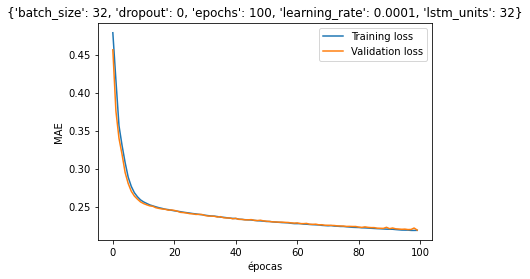

mean_trainMAE: 0.21882589161396027


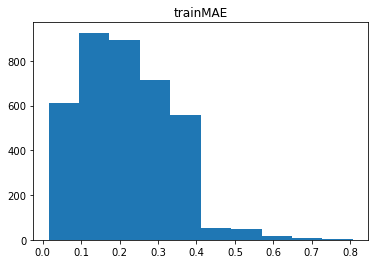

max_trainMAE: 	 0.8068545460700989


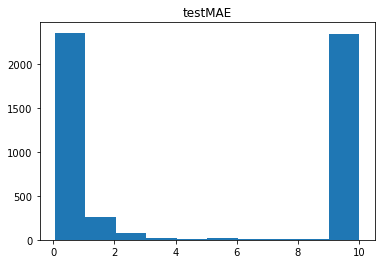

F1: 	 0.877151799687011

#################################################################



In [3]:
# Aplicação do classificador com combinação de parâmetros

grid_params = {
    'batch_size': [32],
    'epochs': [100],
    'lstm_units': [32],
    'dropout': [0],
    'learning_rate': [0.0001]
}

scores_autoencoder = pd.DataFrame()

for params in ParameterGrid(grid_params):
    
    print(f'PARÂMETROS: {params}')
    
    # Define o modelo de rede neural
    lstm_encoder = Sequential([
        LSTM(int(params['lstm_units']), return_sequences=True, input_shape=(X_train_unificado.shape[1], X_train_unificado.shape[2])),
        Dropout(rate=params['dropout']),
        LSTM(int(params['lstm_units']/2), return_sequences=False),
        Dropout(rate=params['dropout']),
    ], name='encoder')
    lstm_decoder = Sequential([
        RepeatVector(X_train_unificado.shape[1]),
        LSTM(int(params['lstm_units']/2), return_sequences=True),
        Dropout(rate=params['dropout']),
        LSTM(int(params['lstm_units']), return_sequences=True),
        Dropout(rate=params['dropout']),
        TimeDistributed(Dense(X_train_unificado.shape[2]))    
    ], name='decoder')
    model = Sequential([lstm_encoder, lstm_decoder])
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mae')
    
    # Treina o modelo
    history = model.fit(X_train_unificado, X_train_unificado, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.4, verbose=0)

    # Gráfico de train e validation loss
    fig1, ax1 = plt.subplots()
    ax1.set_title(f'{params}')
    ax1.plot(history.history['loss'], label=f'Training loss')
    ax1.plot(history.history['val_loss'], label=f'Validation loss')
    ax1.set_xlabel('épocas')
    ax1.set_ylabel('MAE')
    ax1.legend()
    plt.show()

    trainPredict = model.predict(X_train_unificado)
    trainMAE = np.mean(np.mean(np.abs(trainPredict - X_train_unificado), axis=1), axis=1)
    mean_trainMAE = np.mean(trainMAE)
    print(f'mean_trainMAE: {mean_trainMAE}')
    
    fig2, ax2 = plt.subplots()
    ax2.set_title(f'trainMAE')
    ax2.hist(trainMAE)
    plt.show()
    
    max_trainMAE = np.max(trainMAE)
    print(f'max_trainMAE: \t {max_trainMAE}')

    testPredict = model.predict(X_test_unificado)
    testMAE = np.mean(np.mean(np.abs(testPredict - X_test_unificado), axis=1), axis=1)
    
    fig3, ax3 = plt.subplots()
    ax3.set_title(f'testMAE')
    #Para o histograma, todos os valores maiores que 10 setei como 10 para melhor visualização
    testMAE_visualizacao = testMAE
    testMAE_visualizacao[testMAE_visualizacao > 10] = 10
    ax3.hist(testMAE_visualizacao)
    plt.show()
    
    # Será considerada anomalia aquela observação cujo erro de reconstrução seja 
    # acima de um valor especificado como gatilho (usado max_trainMAE)
    y_pred = pd.DataFrame((testMAE >= max_trainMAE)).replace({True:-1,False:1})

    # Calcula as metricas de desempenho
    p, r, f1, _ = precision_recall_fscore_support(y_test_unificado, y_pred, average='micro')
    
    print(f'F1: \t {f1}')
    
    scores_autoencoder = scores_autoencoder.append({'CLASSIFICADOR': params, 
                                'F1': f1}, ignore_index=True)
    print('\n#################################################################\n')

In [4]:
# Tabela com resultados filtrados F1:
scores_autoencoder_table = scores_autoencoder.sort_values(by=['F1'], ascending=False)
scores_autoencoder_table.to_csv(r'./results/5-1_anomaly_detection_scores_autoencoder_simuladas.csv')
scores_autoencoder_table

,CLASSIFICADOR,F1
0,"{'batch_size': 32, 'dropout': 0, 'epochs': 100...",0.877152


### Experimentação com LOF nas características reduzidas do autoencoder:

In [5]:
# A melhor configuração de rede neural será utilizada na calibração do LOF:
scores_autoencoder_table["CLASSIFICADOR"][0]

{'batch_size': 32,
 'dropout': 0,
 'epochs': 100,
 'learning_rate': 0.0001,
 'lstm_units': 32}

In [6]:
# Resimula a rede neural com melhores parâmetros para obter as features encoded em seguida
lstm_encoder = Sequential([
    LSTM(int(scores_autoencoder_table["CLASSIFICADOR"][0]['lstm_units']), return_sequences=True, input_shape=(X_train_unificado.shape[1], X_train_unificado.shape[2])),
    LSTM(int(scores_autoencoder_table["CLASSIFICADOR"][0]['lstm_units']/2), return_sequences=False),
], name='encoder')
lstm_decoder = Sequential([
    RepeatVector(X_train_unificado.shape[1]),
    LSTM(int(scores_autoencoder_table["CLASSIFICADOR"][0]['lstm_units']/2), return_sequences=True),
    LSTM(int(scores_autoencoder_table["CLASSIFICADOR"][0]['lstm_units']), return_sequences=True),
    TimeDistributed(Dense(X_train_unificado.shape[2]))    
], name='decoder')
model = Sequential([lstm_encoder, lstm_decoder])
model.compile(optimizer='adam', loss='mae')
history = model.fit(X_train_unificado, X_train_unificado, epochs=scores_autoencoder_table["CLASSIFICADOR"][0]['epochs'], batch_size=scores_autoencoder_table["CLASSIFICADOR"][0]['batch_size'], validation_split=0.4, verbose=0)

In [7]:
# Obtem as encoded features por amostra
encoder = model.get_layer("encoder")
X_train_unificado_encoded = encoder.predict(X_train_unificado)
X_test_unificado_encoded = encoder.predict(X_test_unificado)

# Testa o LOF com diversos parâmetros
from sklearn.neighbors import LocalOutlierFactor

# LOCAL OUTLIER FACTOR (LOF) - busca de melhores hiperparâmetros
clfs = {}
scores_lof = pd.DataFrame()

lof_params = {
    'n_neighbors': [5, 10, 15, 20],
    'algorithm': ['auto'],
    'metric': ['hamming', 'euclidean', 'manhattan' , 'minkowski'],
    'contamination': ['auto', 0.01, 0.05, 0.10],
    'novelty': [True]
}    
for params in ParameterGrid(lof_params):
    lof_clf = LocalOutlierFactor().set_params(**params)
    clfs[f'Local Outlier Factor (LOF): {params}'] = lof_clf
    
for clf_name, clf in clfs.items():
    clf.fit(X_train_unificado_encoded)
    y_pred = clf.predict(X_test_unificado_encoded)
    p, r, f1, _ = precision_recall_fscore_support(y_test_unificado, y_pred, average='micro')
    scores_lof = scores_lof.append({'CLASSIFICADOR': clf_name, 
                            'F1': f1}, ignore_index=True)

In [8]:
# Dados de F1 LOF ordenados
score_lof_table = scores_lof.sort_values(by=['F1'], ascending=False)
score_lof_table.to_csv(r'./results/5-1_anomaly_detection_scores_lof_simuladas.csv')
score_lof_table

,CLASSIFICADOR,F1
39,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.822379
47,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.822379
43,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.763693
38,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.749804
46,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.749804
...,...,...
60,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.366588
44,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.355243
36,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.355243
56,Local Outlier Factor (LOF): {'algorithm': 'aut...,0.351917


In [9]:
# A melhor configuração para o LOF:
score_lof_table["CLASSIFICADOR"][0]

"Local Outlier Factor (LOF): {'algorithm': 'auto', 'contamination': 'auto', 'metric': 'hamming', 'n_neighbors': 5, 'novelty': True}"

In [10]:
# Calcular tempo total do notebook Jupyter
print(f'Tempo total de execução (hh:mm:ss.ms): {datetime.now() - start_time}')

Tempo total de execução (hh:mm:ss.ms): 0:44:59.881956


## 4. Análise

Tendo em vista os resultados acima, foram identificados os melhores parâmetros para a rede neural:

- 0.904 {'batch_size': 32, 'dropout': 0, 'epochs': 100, 'learning_rate': 0.0001, 'lstm_units': 32}

Com base nesses parâmetros também foi realizada a calibração do classificador LOF nas instâncias simuladas, utilizando as características reduzidas, tendo sido obtidos os seguintes melhores parâmetros:

-  0.820 {'algorithm': 'auto', 'contamination': 'auto', 'metric': 'hamming', 'n_neighbors': 5, 'novelty': True}

Esses parâmetros serão utilizados na etapa subsequente (avaliação em instâncias reais) conforme orientação da banca de qualificação que sugeriu a utilização das instâncias simuladas para definição dos parâmetros.